In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import nltk
import networkx as nx
import sys
import matplotlib.pyplot as plt
import pickle
import community.community_louvain as community_louvain
from collections import defaultdict
import matplotlib.cm as cm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions 
from wordcloud import WordCloud
from collections import Counter
import os 
import textwrap
import seaborn as sns


In [2]:
# Download NLTK stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/alesac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load data

In [3]:
ts_data = pd.read_csv('data/taylor_swift_discography_updated.csv', sep=';', index_col = 'ID')
ts_data # Remove dots in spotify streams

track_name track_musical_genre track_type  \
ID                                                                         
0           Fortnight (feat. Post Malone)           Synth Pop     Single   
1           The Tortured Poets Department           Synth Pop     B-Side   
2    My Boy Only Breaks His Favorite Toys           Synth Pop     B-Side   
3                                Down Bad                 R&B     B-Side   
4                         So Long, London           Synth Pop     B-Side   
..                                    ...                 ...        ...   
572                              Our Song             Country     Single   
573         I'm Only Me When I'm With You         Country Pop     B-Side   
574                             Invisible         Country Pop     B-Side   
575                A Perfectly Good Heart         Country Pop     B-Side   
576  Teardrops on My Guitar - Pop Version         Country Pop     B-Side   

     duration_ms      feature track_videoclip videoclip_views spotify_streams  \
ID                                                                              
0         228965  Post Malone              No               0       648525069   
1         293048           No              No               0       206954130   
2         203801           No              No               0       238016975   
3         261228           No              No               0       318375377   
4         262974           No              No               0       253712712   
..           ...          ...             ...             ...             ...   
572       201106           No             Yes     214.767.237     328.676.348   
573       213053           No             Yes      41.410.315      49.912.790   
574       203226           No              No               0      34.315.147   
575       220146           No              No               0      25.204.096   
576       179066           No              No               0      32.775.607   

     spotify_global_peak                                         album  ...  \
ID                                                                      ...   
0                      1  The Tortured Poets Department: The Anthology  ...   
1                      6  The Tortured Poets Department: The Anthology  ...   
2                      7  The Tortured Poets Department: The Anthology  ...   
3                      2  The Tortured Poets Department: The Anthology  ...   
4                      4  The Tortured Poets Department: The Anthology  ...   
..                   ...                                           ...  ...   
572                    0                                  Taylor Swift  ...   
573                    0                                  Taylor Swift  ...   
574                    0                                  Taylor Swift  ...   
575                    0                                  Taylor Swift  ...   
576                    0                                  Taylor Swift  ...   

                                      uri acousticness danceability energy  \
ID                                                                           
0    spotify:track:6dODwocEuGzHAavXqTbwHv      0.50200        0.504  0.386   
1    spotify:track:4PdLaGZubp4lghChqp8erB      0.04830        0.604  0.428   
2    spotify:track:7uGYWMwRy24dm7RUDDhUlD      0.13700        0.596  0.563   
3    spotify:track:1kbEbBdEgQdQeLXCJh28pJ      0.56000        0.541  0.366   
4    spotify:track:7wAkQFShJ27V8362MqevQr      0.73000        0.423  0.533   
..                                    ...          ...          ...    ...   
572  spotify:track:15DeqWWQB4dcEWzJg15VrN      0.11100        0.668  0.672   
573  spotify:track:0JIdBrXGSJXS72zjF9ss9u      0.00452        0.563  0.934   
574  spotify:track:5OOd01o2YS1QFwdpVLds3r      0.63700        0.612  0.394   
575  spotify:track:1spLfUJxtyVyiKKTegQ2r4      0.00349        0.483  0.751   
576  spotify:track:4pJi1

In [4]:
#print size of the dataset
rows, columns = ts_data.shape
print('Number of rows: ', rows)
print('Number of columns: ', columns)

Number of rows:  577
Number of columns:  27


In [5]:
# print name of columns
print(ts_data.columns)

Index(['track_name', 'track_musical_genre', 'track_type', 'duration_ms',
       'feature', 'track_videoclip', 'videoclip_views', 'spotify_streams',
       'spotify_global_peak', 'album', 'track_number', 'album_musical_genre',
       'album_type', 'release_date', 'album_physical_sales', 'track_lyrics',
       'track_theme', 'uri', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object')


In [6]:
# change the type of certain columns of the dataset
ts_data['release_date'] = pd.to_datetime(ts_data['release_date'], format='%d/%m/%Y')
ts_data['spotify_streams'] = ts_data['spotify_streams'].str.replace('.', '')
ts_data['spotify_streams'] = pd.to_numeric(ts_data['spotify_streams'], errors='coerce')

In [7]:
row_index = 3  # Replace with the desired row index

lyrics = ts_data.loc[row_index, 'track_lyrics']
print(lyrics)


Did you really beam me up? In a cloud of sparkling dust Just to do experiments on Tell me I was the chosen one Show me that this world is bigger than us Then sent me back where I came from For a moment I knew cosmic love Now I'm down bad crying at the gym Everything comes out teenage petulance "What if I can't have him" "I might just die, it would make no difference." Down bad, waking up in blood Staring at the sky, come back and pick me up What if I can't have us. I might just not get up I might stay down bad What if I can't have him Down bad What if I can't have him Did you take all my old clothes? Just to leave me here naked and alone In a field in my same old town That somehow seems so hollow now They'll say I'm nuts if I talk about the existence of you For a moment I was heaven struck Now I'm down bad crying at the gym Everything comes out teenage petulance "What if I can't have him" "I might just die, it would make no difference." Down bad, waking up in blood Staring at the sky, 

### We know that there are duplicates, let's print for each song the number of times it appears

In [8]:
ts_data['track_name'].value_counts()

track_name
Sweet Nothing                           3
Karma                                   3
Labyrinth                               3
Bejeweled                               3
Maroon                                  3
                                       ..
Stay Beautiful                          1
Should've Said No                       1
Mary's Song (Oh My My My)               1
A Perfectly Good Heart                  1
Teardrops on My Guitar - Pop Version    1
Name: count, Length: 361, dtype: int64

### Merge columns with exaclty the same trackname

In [9]:
def merge_rows_with_same_name(df, key_column='track_name'):
    # Group by the key_column
    grouped = df.groupby(key_column)

    def merge_values(series):
        unique_values = series.dropna().unique()
        if len(unique_values) == 1:
            return unique_values[0]
        else:
            return list(unique_values)

    merged_df = grouped.agg({col: merge_values for col in df.columns if col != key_column}).reset_index()
    
    return merged_df

In [10]:
ts_data = merge_rows_with_same_name(ts_data)

In [11]:
print(ts_data['track_name'].value_counts())
print(ts_data.shape)

track_name
willow                                         1
"Slut!" (Taylor's Version) (From The Vault)    1
...Ready For It?                               1
22                                             1
22 (Taylor's Version)                          1
                                              ..
Anti-Hero                                      1
Babe                                           1
Babe (Taylor's Version) (From The Vault)       1
Back To December                               1
Back To December (Taylor's Version)            1
Name: count, Length: 361, dtype: int64
(361, 27)


In [12]:
# Flatten the 'album' column if it contains lists
flattened_albums = ts_data['album'].explode()  # Explodes lists into separate rows
unique_albums = flattened_albums.dropna().unique()
print(unique_albums)



["1989 (Taylor's Version) [Deluxe]" "1989 (Taylor's Version)" 'reputation'
 'reputation Stadium Tour Surprise Song Playlist' 'Red (Deluxe Edition)'
 'Red' "Red (Taylor's Version)" 'Taylor Swift' 'Lover'
 '1989 (Deluxe Edition)' '1989' 'Midnights (The Til Dawn Edition)'
 'Midnights (3am Edition)' 'Midnights' 'Speak Now (Deluxe Edition)'
 'Speak Now' "Speak Now (Taylor's Version)" 'Speak Now World Tour Live'
 'Live From Clear Channel Stripped 2008' 'Fearless Platinum Edition'
 'Fearless' "Fearless (Taylor's Version)"
 'The Tortured Poets Department: The Anthology'
 'The Tortured Poets Department'
 'folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]'
 'folklore (deluxe version)' 'folklore' 'evermore (deluxe version)'
 'evermore']


In [13]:
# Remove æive album because we don't have critics on it and some songs don't have lyrics
ts_data = ts_data[ts_data['album'] != 'Speak Now World Tour Live']


# Build the network

### Clean the lyrics

In [14]:
def clean_text(text):
    # If the input is a list, join elements into a single string
    if isinstance(text, list):
        text = ' '.join(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Expand contractions (e.g., "I'm" -> "I am")
    text = contractions.fix(text)
    
    # Remove text enclosed in square brackets, like [Verse 1: Taylor Swift]
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Lemmatization (convert words to their root form)
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    
    return text



In [15]:
# Apply text cleaning
ts_data['cleaned_lyrics'] = ts_data['track_lyrics'].apply(clean_text)

# Display the cleaned data
ts_data[['track_name', 'cleaned_lyrics']].head()

track_name  \
0  "Slut!" (Taylor's Version) (From The Vault)   
1                             ...Ready For It?   
2                                           22   
3                        22 (Taylor's Version)   
4                       A Perfectly Good Heart   

                                      cleaned_lyrics  
0  flamingo pink sunrise boulevard clink clink yo...  
1  knew killer first time saw wondered many girl ...  
2  feel like perfect night dress like hipster mak...  
3  feel like perfect night dress like hipster mak...  
4  would want break perfectly good heart would wa...

### Compute similarity between songs using tf-idf score and consine similarity

In [16]:
def compute_tfidf_similarity(data, text_column, index_column):
    """
    Compute TF-IDF scores and a similarity matrix for a dataset.

    Parameters:
    - data (pd.DataFrame): The input dataset.
    - text_column (str): The column containing text data for TF-IDF computation.
    - index_column (str): The column to use as the index for similarity and TF-IDF DataFrames.

    Returns:
    - tfidf_df (pd.DataFrame): DataFrame of TF-IDF scores.
    - similarity_df (pd.DataFrame): Pairwise similarity matrix based on cosine similarity.
    """
    # Step 1: Calculate TF-IDF scores
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(data[text_column])

    # Step 2: Get feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Step 3: Convert the TF-IDF matrix to a DataFrame
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=feature_names,
        index=data[index_column]
    )

    # Step 4: Compute the similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Step 5: Convert the similarity matrix to a DataFrame
    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=data[index_column],
        columns=data[index_column]
    )

    # Return both TF-IDF and similarity DataFrames
    return tfidf_df, similarity_df

In [17]:
# Compute TF-IDF and similarity matrix for the dataset
tfidf_df, similarity_df = compute_tfidf_similarity(
    data=ts_data,
    text_column='cleaned_lyrics',
    index_column='track_name'
)

# Display a sample of the TF-IDF and similarity matrices
print("TF-IDF DataFrame:")
print(tfidf_df.shape)
tfidf_df.head()

TF-IDF DataFrame:
(345, 4303)


158  16th   17  1830s  1944  \
track_name                                                                 
"Slut!" (Taylor's Version) (From The Vault)  0.0   0.0  0.0    0.0   0.0   
...Ready For It?                             0.0   0.0  0.0    0.0   0.0   
22                                           0.0   0.0  0.0    0.0   0.0   
22 (Taylor's Version)                        0.0   0.0  0.0    0.0   0.0   
A Perfectly Good Heart                       0.0   0.0  0.0    0.0   0.0   

                                             1950s  1958  2003  230   25  ...  \
track_name                                                                ...   
"Slut!" (Taylor's Version) (From The Vault)    0.0   0.0   0.0  0.0  0.0  ...   
...Ready For It?                               0.0   0.0   0.0  0.0  0.0  ...   
22                                             0.0   0.0   0.0  0.0  0.0  ...   
22 (Taylor's Version)                          0.0   0.0   0.0  0.0  0.0  ...   
A Perfectly Good Heart                         0.0   0.0   0.0  0.0  0.0  ...   

                                                  you  youi     young  \
track_name                                                              
"Slut!" (Taylor's Version) (From The Vault)  0.022968   0.0  0.048119   
...Ready For It?                             0.048531   0.0  0.000000   
22                                           0.040954   0.0  0.000000   
22 (Taylor's Version)                        0.040954   0.0  0.000000   
A Perfectly Good Heart                       0.000000   0.0  0.000000   

                                              younger  youplease  your  yours  \
track_name                                                                      
"Slut!" (Taylor's Version) (From The Vault)  0.000000        0.0   0.0    0.0   
...Ready For It?                             0.052495        0.0   0.0    0.0   
22                                           0.000000        0.0   0.0    0.0   
22 (Taylor's Version)                        0.000000        0.0   0.0    0.0   
A Perfectly Good Heart                       0.000000        0.0   0.0    0.0   

                                             yourself  youth  zlister  
track_name                                                             
"Slut!" (Taylor's Version) (From The Vault)       0.0    0.0      0.0  
...Ready For It?                                  0.0    0.0      0.0  
22                                                0.0    0.0      0.0  
22 (Taylor's Version)                             0.0    0.0      0.0  
A Perfectly Good Heart                            0.0    0.0      0.0  

[5 rows x 4303 columns]

In [18]:
print("Similarity Matrix:")
print(similarity_df.shape)
similarity_df.head(10)

Similarity Matrix:
(345, 345)


track_name                                          "Slut!" (Taylor's Version) (From The Vault)  \
track_name                                                                                        
"Slut!" (Taylor's Version) (From The Vault)                                            1.000000   
...Ready For It?                                                                       0.039831   
22                                                                                     0.025628   
22 (Taylor's Version)                                                                  0.025628   
A Perfectly Good Heart                                                                 0.035435   
A Place in this World                                                                  0.039183   
Afterglow                                                                              0.084422   
All Too Well                                                                           0.121836   
All Too Well (10 Minute Version) (Taylor's Vers...                                     0.116570   
All Too Well (Taylor's Version)                                                        0.121836   

track_name                                          ...Ready For It?  \
track_name                                                             
"Slut!" (Taylor's Version) (From The Vault)                 0.039831   
...Ready For It?                                            1.000000   
22                                                          0.061747   
22 (Taylor's Version)                                       0.061747   
A Perfectly Good Heart                                      0.036758   
A Place in this World                                       0.078595   
Afterglow                                                   0.058289   
All Too Well                                                0.063346   
All Too Well (10 Minute Version) (Taylor's Vers...          0.044343   
All Too Well (Taylor's Version)                             0.063346   

track_name                                                22  \
track_name                                                     
"Slut!" (Taylor's Version) (From The Vault)         0.025628   
...Ready For It?                                    0.061747   
22                                                  1.000000   
22 (Taylor's Version)                               1.000000   
A Perfectly Good Heart                              0.025080   
A Place in this World                               0.083865   
Afterglow                                           0.087050   
All Too Well                                        0.078212   
All Too Well (10 Minute Version) (Taylor's Vers...  0.054785   
All Too Well (Taylor's Version)                     0.078212   

track_name                                          22 (Taylor's Version)  \
track_name                                                                  
"Slut!" (Taylor's Version) (From The Vault)                      0.025628   
...Ready For It?                                                 0.061747   
22                                                               1.000000   
22 (Taylor's Version)                                            1.000000   
A Perfectly Good Heart                                           0.025080   
A Place in this World                                            0.083865   
Afterglow                                                        0.087050   
All Too Well                                                     0.078212   
All Too Well (10 Minute Version) (Taylor's Vers...               0.054785   
All Too Well (Taylor's Version)                                  0.078212   

track_name                                          A Perfectly Good Heart  \
track_name                                                                   
"Slut!" (Taylor's Version) (From The Vault)                       0.035435   
...Ready For It?  

In [19]:
similarity_threshold = 0.97

# Initialize a set to store the pairs
high_similarity_pairs = set()

# Iterate through the similarity matrix
for song1 in similarity_df.index:
    for song2 in similarity_df.columns:
        # Exclude self-similarity and check if the score exceeds the threshold
        if song1 != song2 and similarity_df.at[song1, song2] > similarity_threshold:
            # Add the pair to the set (ensuring each pair is unique)
            pair = tuple(sorted((song1, song2)))
            high_similarity_pairs.add((pair[0], pair[1], similarity_df.at[song1, song2]))

# Convert the set to a DataFrame
high_similarity_df = pd.DataFrame(high_similarity_pairs, columns=["Song1", "Song2", "Similarity"])
print(high_similarity_df.shape)
high_similarity_df.head(50)


(133, 3)


Song1  \
0                                   my tears ricochet   
1                                       I Know Places   
2                                         Treacherous   
3                                How You Get The Girl   
4                                    Out Of The Woods   
5                                             Haunted   
6                                         Tell Me Why   
7                                      State Of Grace   
8                                           Last Kiss   
9                                                Mine   
10                  State Of Grace (Taylor's Version)   
11                                              Style   
12                                              peace   
13  Teardrops On My Guitar - Live From Clear Chann...   
14                     Treacherous (Taylor's Version)   
15                                     State Of Grace   
16                   I Know Places (Taylor's Version)   
17                                      The Lucky One   
18                                        I Almost Do   
19                                         Wonderland   
20                        Fearless (Taylor's Version)   
21                                 You Belong With Me   
22                                    Picture To Burn   
23                                  this is me trying   
24                                        Blank Space   
25                                          This Love   
26                             Everything Has Changed   
27                                              seven   
28                                        Begin Again   
29                                   Forever & Always   
30  State Of Grace (Acoustic Version) (Taylor's Ve...   
31  Forever & Always (Piano Version) (Taylor's Ver...   
32                                              the 1   
33  State Of Grace (Acoustic Version) (Taylor's Ve...   
34                     Blank Space (Taylor's Version)   
35                                         mirrorball   
36                                         Better Man   
37  Forever & Always (Piano Version) (Taylor's Ver...   
38                                    illicit affairs   
39                                        White Horse   
40                                      I Know Places   
41                                                 22   
42                                      Never Grow Up   
43                                          Dear John   
44                                           epiphany   
45                                        Untouchable   
46                                Come Back...Be Here   
47                      Love Story (Taylor's Version)   
48                                             Change   
49                                             august   

                                                Song2  Similarity  
0   my tears ricochet - the long pond studio sessions         1.0  
1                          I Know Places - Voice Memo         1.0  
2                      Treacherous (Taylor's Version)         1.0  
3             How You Get The Girl (Taylor's Version)         1.0  
4                 Out Of The Woods (Taylor's Version)         1.0  
5                          Haunted - Acoustic Version         1.0  
6                      Tell Me Why (Taylor's Version)         1.0  
7                   State Of Grace (Taylor's Version)         1.0  
8                        Last Kiss (Taylor's Version)         1.0  
9                             Mine (Taylor's Version)         1.0  
10                          State Of Grace - Acoustic         1.0  
11                           Style (Taylor's Version)         1.0  
12              peace - the long pond studio sessions         1.0  
13               Teardrops on My Guitar - Pop Version         1.0  
14              Treacherous - Original Demo Recording         1.0  
15  State Of Grace (Acoustic Version) (Taylor's Ve..

In [20]:
def merge_rows(row1, row2, columns):
    """
    Merges two rows by comparing column values.
    If values differ, save as a list; otherwise, keep a single value.
    Handles cases where fields might already be lists.
    """
    merged_row = {}
    for col in columns:
        values = []
        for value in [row1[col], row2[col]]:
            if isinstance(value, list):
                values.extend(value)  # Extend if already a list
            else:
                values.append(value)  # Append single values
        
        # Ensure values are unique and check for pre-existing lists
        unique_values = pd.Series(values).dropna().unique()
        # If only one unique value exists, keep it; otherwise, store as a list
        merged_row[col] = unique_values[0] if len(unique_values) == 1 else list(unique_values)
    return merged_row

# Function to merge the dataset based on high similarity pairs
def merge_high_similarity_rows(dataset, high_similarity_df):
    # Copy the dataset to avoid modifying the original
    updated_dataset = dataset.copy()
    columns = dataset.columns.tolist()
    
    for _, (song1, song2, _) in high_similarity_df.iterrows():
        # Find the rows corresponding to the pair
        row1 = updated_dataset.loc[updated_dataset['track_name'] == song1]
        row2 = updated_dataset.loc[updated_dataset['track_name'] == song2]
        
        if not row1.empty and not row2.empty:
            row1 = row1.iloc[0]
            row2 = row2.iloc[0]
            
            # Determine the shortest track name
            shortest_name = song1 if len(song1) <= len(song2) else song2
            
            # Merge the two rows
            merged_row = merge_rows(row1, row2, columns)
            merged_row['track_name'] = shortest_name  # Set the shortest name as the track name
            
            # Remove the original rows
            updated_dataset = updated_dataset[~updated_dataset['track_name'].isin([song1, song2])]
            
            # Add the merged row
            updated_dataset = pd.concat([updated_dataset, pd.DataFrame([merged_row])], ignore_index=True)
    
    return updated_dataset

# Apply the merging function to the dataset
updated_ts_data = merge_high_similarity_rows(ts_data, high_similarity_df)



In [21]:
updated_ts_data

track_name track_musical_genre  \
0    "Slut!" (Taylor's Version) (From The Vault)           Synth Pop   
1                               ...Ready For It?          Electropop   
2                         A Perfectly Good Heart         Country Pop   
3                          A Place in this World         Country Pop   
4                                      Afterglow                 Pop   
..                                           ...                 ...   
230                                  Hey Stephen         Country Pop   
231                                     Innocent            Pop Rock   
232                      the lakes - bonus track          Indie Folk   
233                                  Blank Space          Electropop   
234                                 Shake It Off           Dance Pop   

                       track_type                       duration_ms feature  \
0                          Single                            180381      No   
1                          Single                            208186      No   
2                          B-Side                            220146      No   
3                          B-Side                  [202080, 199200]      No   
4                          B-Side                            223293      No   
..                            ...                               ...     ...   
230                        B-Side  [256040, 254320, 254306, 254254]      No   
231                        B-Side                  [302253, 301221]      No   
232        [Special Deluxe, Live]                  [211813, 199733]      No   
233  [Single, B-Side, Voice Memo]          [231826, 231833, 131186]      No   
234              [Single, B-Side]                  [219200, 219209]      No   

    track_videoclip     videoclip_views                   spotify_streams  \
0                No                   0                         239579759   
1               Yes         350.707.005                         695895392   
2                No                   0                          25204096   
3                No                   0                          40680546   
4                No                   0                         368409481   
..              ...                 ...                               ...   
230              No                   0              [48880134, 86368640]   
231              No                   0              [51675352, 44117403]   
232              No                   0             [147911887, 14461249]   
233       [No, Yes]  [0, 3.404.289.651]  [1779730252, 151282408, 4829873]   
234       [No, Yes]  [0, 3.423.261.000]           [1367910021, 101800187]   

    spotify_global_peak                                              album  \
0                     2  [1989 (Taylor's Version) [Deluxe], 1989 (Taylo...   
1                     3                                         reputation   
2                     0                                       Taylor Swift   
3                     0  [reputation Stadium Tour Surprise Song Playlis...   
4                    38                                              Lover   
..                  ...                                                ...   
230             [0, 26]  [reputation Stadium Tour Surprise Song Playlis...   
231             [0, 23]  [Speak Now (Deluxe Edition), Speak Now, Speak ...   
232                   0  [folklore: the long pond studio sessions (from...   
233          [14, 3, 0]  [1989 (Deluxe Edition), 1989, 1989 (Taylor's V...   
234            [54, 11]  [1989 (Deluxe Edition), 1989, 1989 (Taylor's V...   

     ...                           acousticness  \
0    ...                         [0.309, 0.345]   
1    ...                                 0.0527   
2    ...                                0.00349   
3    ...                        [0.0577, 0.051]   
4    ...                                   0.13   
..   ...                                    ...   
230  

In [22]:
# Compute TF-IDF and similarity matrix for the dataset
tfidf_df, similarity_df = compute_tfidf_similarity(
    data=updated_ts_data,
    text_column='cleaned_lyrics',
    index_column='track_name'
)

### Extract top 10 words per song 

In [23]:
def extract_top_words(tfidf_df, top_n=10):
    """
    Extracts the top N highest-scoring words for each song from the TF-IDF DataFrame.

    Parameters:
        tfidf_df (DataFrame): The TF-IDF DataFrame with songs as rows and words as columns.
        top_n (int): The number of top words to extract for each song.

    Returns:
        DataFrame: A DataFrame with 'track_name' and 'top_words' columns.
    """
    top_words = []

    # Iterate over each song in the TF-IDF DataFrame
    for track_name, row in tfidf_df.iterrows():
        # Get the top N words with the highest TF-IDF scores
        top_word_indices = row.nlargest(top_n).index
        top_word_scores = row.nlargest(top_n).values
        words_with_scores = [(word, score) for word, score in zip(top_word_indices, top_word_scores)]
        
        # Append the song and its top words to the list
        top_words.append({
            'track_name': track_name,
            'top_words': words_with_scores
        })

    # Convert the list to a DataFrame
    top_words_df = pd.DataFrame(top_words)
    return top_words_df

# Extract top 10 words for each song
top_words_df = extract_top_words(tfidf_df, top_n=20)

# Display the resulting DataFrame
top_words_df.head()


track_name  \
0  "Slut!" (Taylor's Version) (From The Vault)   
1                             ...Ready For It?   
2                       A Perfectly Good Heart   
3                        A Place in this World   
4                                    Afterglow   

                                           top_words  
0  [(might, 0.3569688448161781), (slut, 0.3053722...  
1  [(begin, 0.5379038688265549), (game, 0.3842918...  
2  [(perfectly, 0.42725262582385404), (want, 0.40...  
3  [(oh, 0.41883244597634794), (own, 0.3845367444...  
4  [(want, 0.3663974890957303), (lose, 0.32328300...

1733340 1993770030


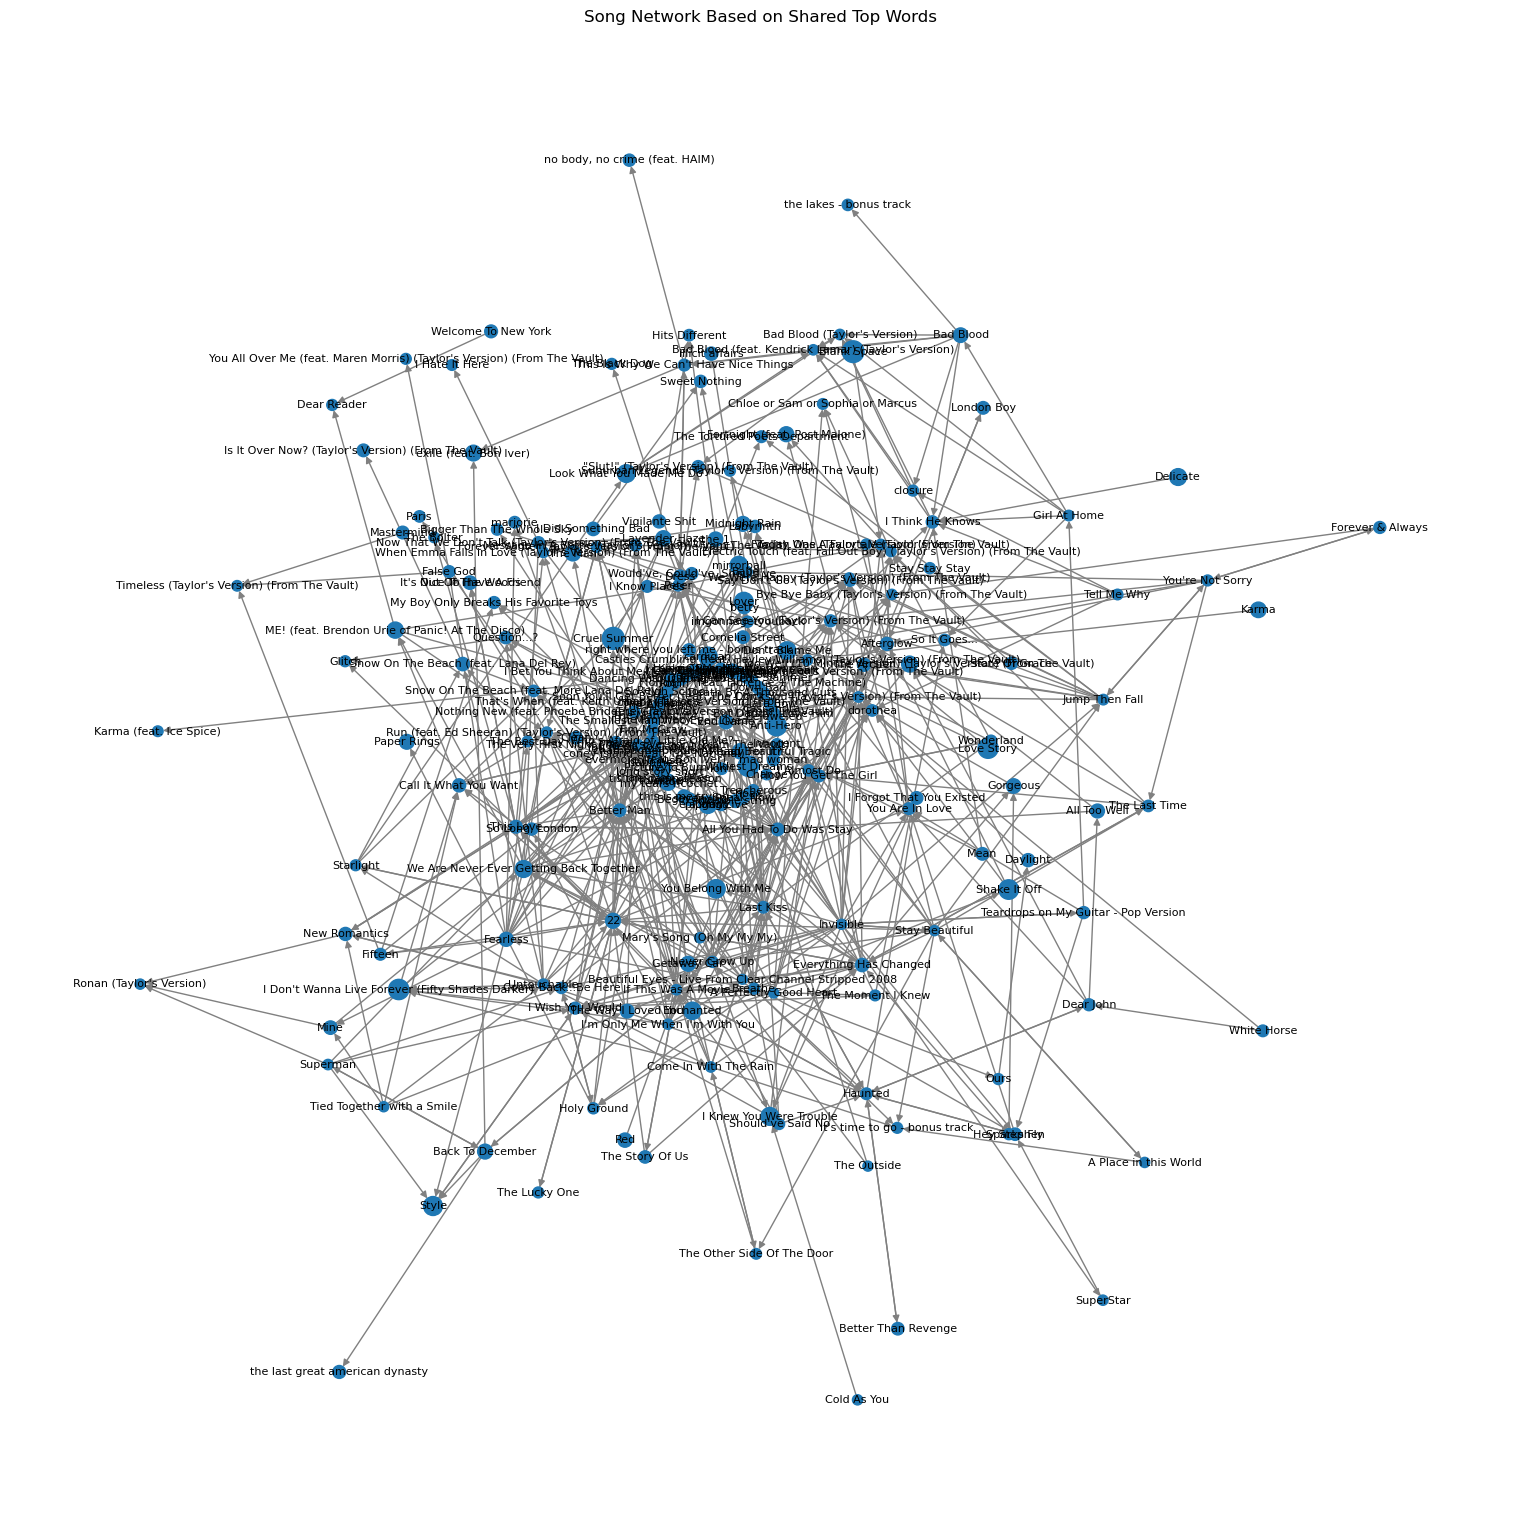

Number of nodes: 235
Number of edges: 496


In [24]:
import networkx as nx

def build_song_network(ts_data, top_words_df, min_shared_words=1):
    """
    Builds a directed song network based on shared top words and release dates.

    Parameters:
        ts_data (DataFrame): The original dataset with song metadata, including release dates.
        top_words_df (DataFrame): DataFrame containing track names and their top words.
        min_shared_words (int): Minimum number of shared words required to create an edge.

    Returns:
        nx.DiGraph: A directed network of songs.
    """
    G = nx.DiGraph()

    # Build a mapping of song to top words
    song_to_words = dict(zip(top_words_df['track_name'], top_words_df['top_words']))

    # Add nodes to the graph
    for _, row in ts_data.iterrows():
        G.add_node(
            row['track_name'], 
            release_date=row['release_date'],
            genre=row['track_musical_genre'], 
            spotify_streams=row['spotify_streams'],
            album = row['album']
        )

    # Add edges based on shared words and release dates
    for song1, words1 in song_to_words.items():
        for song2, words2 in song_to_words.items():
            if song1 != song2:
                # Find common words between the two songs
                common_words = set([w[0] for w in words1]).intersection([w[0] for w in words2])
                if len(common_words) >= min_shared_words:
                    # Determine the direction of the edge based on release date
                    date1 = ts_data.loc[ts_data['track_name'] == song1, 'release_date'].iloc[0]
                    date2 = ts_data.loc[ts_data['track_name'] == song2, 'release_date'].iloc[0]

                    # Handle lists in release_date
                    if isinstance(date1, list):
                        date1 = min(date1)
                    if isinstance(date2, list):
                        date2 = min(date2)

                    # Add edge based on release date comparison
                    if date1 < date2:
                        G.add_edge(song1, song2, weight=len(common_words))
                    else:
                        G.add_edge(song2, song1, weight=len(common_words))

    return G

# Build the song network
net = build_song_network(updated_ts_data, top_words_df, min_shared_words=3)

node_sizes = []
for node in net.nodes:
    streams = net.nodes[node]['spotify_streams']
    if isinstance(streams, list):
        # If spotify_streams is a list, sum the values
        node_sizes.append(sum(streams))
    else:
        # If it's a single value, just append it
        node_sizes.append(streams)

# Normalize the node sizes to make them visually appropriate
max_streams = max(node_sizes)
min_streams = min(node_sizes)
print(min_streams, max_streams)
normalized_sizes = [50 + (size - min_streams) / (max_streams - min_streams) * 200 for size in node_sizes]



plt.figure(figsize=(15, 15))
pos = nx.kamada_kawai_layout(net)  
nx.draw(
    net, pos, with_labels=True, 
    node_size=normalized_sizes, font_size=8, edge_color="gray", arrowsize=10
)
plt.title("Song Network Based on Shared Top Words")
plt.show()

# Display network statistics
print(f"Number of nodes: {net.number_of_nodes()}")
print(f"Number of edges: {net.number_of_edges()}")


In [25]:
# Save the network 
with open('song_network.pkl', 'wb') as f:
    pickle.dump(net, f)

In [26]:
updated_ts_data.to_pickle("ts_data.pkl")
print("DataFrame saved as 'updated_ts_data.pkl'")

DataFrame saved as 'updated_ts_data.pkl'


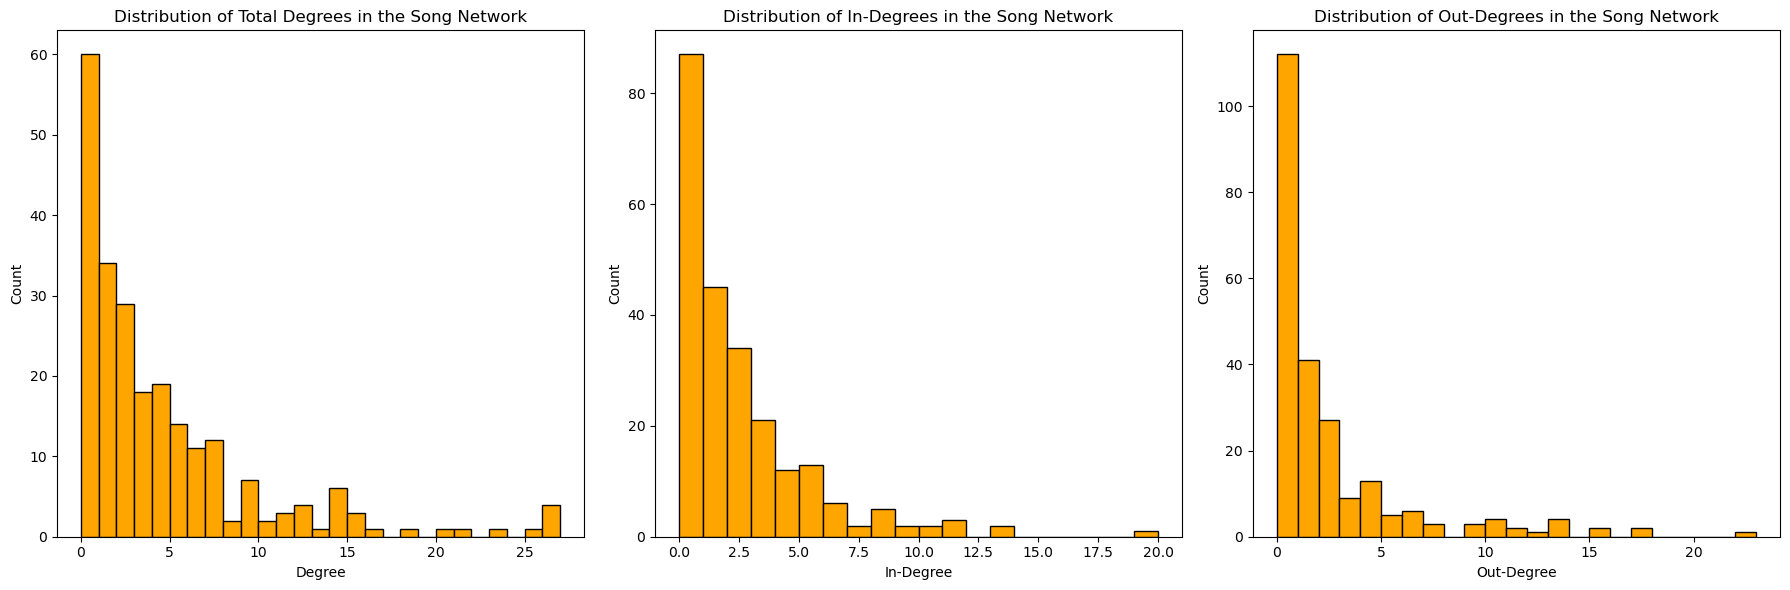

In [27]:
# Calculate degree, in-degree, and out-degree for each node
degrees = [d for n, d in net.degree()]
in_degrees = [d for n, d in net.in_degree()]
out_degrees = [d for n, d in net.out_degree()]

# Plot degree distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total Degree Distribution
axes[0].hist(degrees, bins=range(0, max(degrees) + 1), color='orange', edgecolor='black')
axes[0].set_title('Distribution of Total Degrees in the Song Network')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')

# In-Degree Distribution
axes[1].hist(in_degrees, bins=range(0, max(in_degrees) + 1), color='orange', edgecolor='black')
axes[1].set_title('Distribution of In-Degrees in the Song Network')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Count')

# Out-Degree Distribution
axes[2].hist(out_degrees, bins=range(0, max(out_degrees) + 1), color='orange', edgecolor='black')
axes[2].set_title('Distribution of Out-Degrees in the Song Network')
axes[2].set_xlabel('Out-Degree')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()



In [28]:
from tabulate import tabulate

# Find the top 5 songs with the highest in-degree
top_in_degree = sorted(net.in_degree(), key=lambda x: x[1], reverse=True)[:5]
in_degree_table = [[song, degree] for song, degree in top_in_degree]

# Find the top 5 songs with the highest out-degree
top_out_degree = sorted(net.out_degree(), key=lambda x: x[1], reverse=True)[:5]
out_degree_table = [[song, degree] for song, degree in top_out_degree]

# Print tables
print("Top 5 Songs with Highest In-Degree (Most Influenced):")
print(tabulate(in_degree_table, headers=["Song", "In-Degree"], tablefmt="grid"))

print("\nTop 5 Songs with Highest Out-Degree (Most Influential):")
print(tabulate(out_degree_table, headers=["Song", "Out-Degree"], tablefmt="grid"))


Top 5 Songs with Highest In-Degree (Most Influenced):
+------------------------------------------------------------+-------------+
| Song                                                       |   In-Degree |
+============================================================+=============+
| The Very First Night (Taylor's Version) (From The Vault)   |          20 |
+------------------------------------------------------------+-------------+
| Don't You (Taylor's Version) (From The Vault)              |          13 |
+------------------------------------------------------------+-------------+
| Better Man                                                 |          13 |
+------------------------------------------------------------+-------------+
| Run (feat. Ed Sheeran) (Taylor's Version) (From The Vault) |          11 |
+------------------------------------------------------------+-------------+
| Everything Has Changed                                     |          11 |
+---------------------

# Communities

In [29]:
# Make graph undirected
undirected_net = net.to_undirected()

In [30]:
# Extract the Giant Connected Component (GCC)
largest_cc = max(nx.connected_components(undirected_net), key=len)
gcc = undirected_net.subgraph(largest_cc).copy()
print(f"GCC has {gcc.number_of_nodes()} nodes and {gcc.number_of_edges()} edges")

GCC has 173 nodes and 464 edges


In [31]:
# Detect communities in the GCC
# partition = community_louvain.best_partition(gcc, random_state=42)

# # Save the partition to ensure consistency
# with open("partition.pkl", "wb") as f:
#     pickle.dump(partition, f)

# Load partitions
with open("partition.pkl", "rb") as f:
    partition = pickle.load(f)

# Compute modularity for the GCC
modularity = community_louvain.modularity(partition, gcc)
print(f"Number of communities in GCC: {len(set(partition.values()))}")
print(f"Modularity value for GCC: {modularity}")

Number of communities in GCC: 9
Modularity value for GCC: 0.4877700531340194


In [32]:
# Group nodes by community and name them after the song with highest degree

communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

community_names = {}
for comm_id, nodes in communities.items():
    # Compute degree for each node in the community
    degrees = {node: undirected_net.degree(node) for node in nodes}
    # Find the node with the highest degree
    highest_degree_node = max(degrees, key=degrees.get)
    community_names[comm_id] = highest_degree_node

print("Communities named by highest-degree song:")
print(community_names)


Communities named by highest-degree song:
{0: 'Invisible', 1: 'Afterglow', 2: 'Stay Beautiful', 3: 'All You Had To Do Was Stay', 4: 'I Think He Knows', 5: 'Better Man', 6: "The Very First Night (Taylor's Version) (From The Vault)", 7: 'Untouchable', 8: 'If This Was A Movie'}


/home/alesac/miniconda/envs/social_graph/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


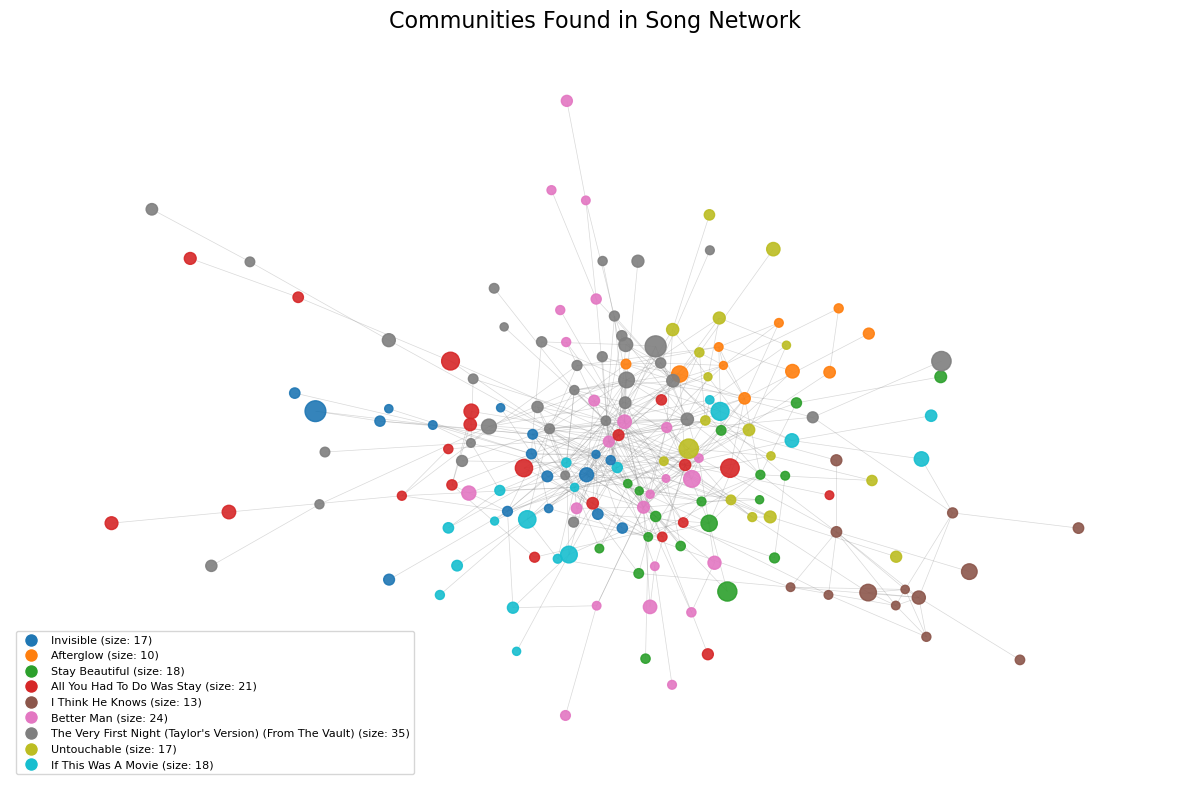

In [33]:
# Prepare a color map for communities
num_communities = len(communities)
colors = plt.get_cmap("tab10", num_communities)

# Assign a color to each node based on its community
node_colors = [colors(partition[node]) for node in gcc.nodes()]

# Assign node sizes based on Spotify streams (or degree if not available)
node_sizes = [
    30 + (sum(gcc.nodes[node].get("spotify_streams", [1])) / 1e7) 
    if isinstance(gcc.nodes[node].get("spotify_streams"), list)
    else 30 + (gcc.nodes[node].get("spotify_streams", 1) / 1e7) 
    for node in gcc.nodes()
]

# Compute layout
pos = nx.spring_layout(gcc, seed=42)  # Force-directed layout with a fixed seed for consistency

# Plot the graph
plt.figure(figsize=(12,8))
nx.draw_networkx_nodes(
    gcc,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    cmap="tab10",
    alpha=0.9
)
nx.draw_networkx_edges(
    gcc,
    pos,
    alpha=0.3,
    edge_color="gray",
    width=0.5
)

# Add a legend for communities
handles = []
for comm_id, name in community_names.items():
    handles.append(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=colors(comm_id),
            markersize=10,
            label=f"{name} (size: {len(communities[comm_id])})"
        )
    )
plt.legend(
    handles=handles,
    loc="lower left",             # Align the lower-left corner of the legend
    bbox_to_anchor=(0, 0),        # To the lower-left of the axes
    ncol=1,                       # Single-column legend
    frameon=True,                 # Show legend frame
    fontsize=8,                   # Set font size
)


# Finalize and show the plot
plt.title("Communities Found in Song Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


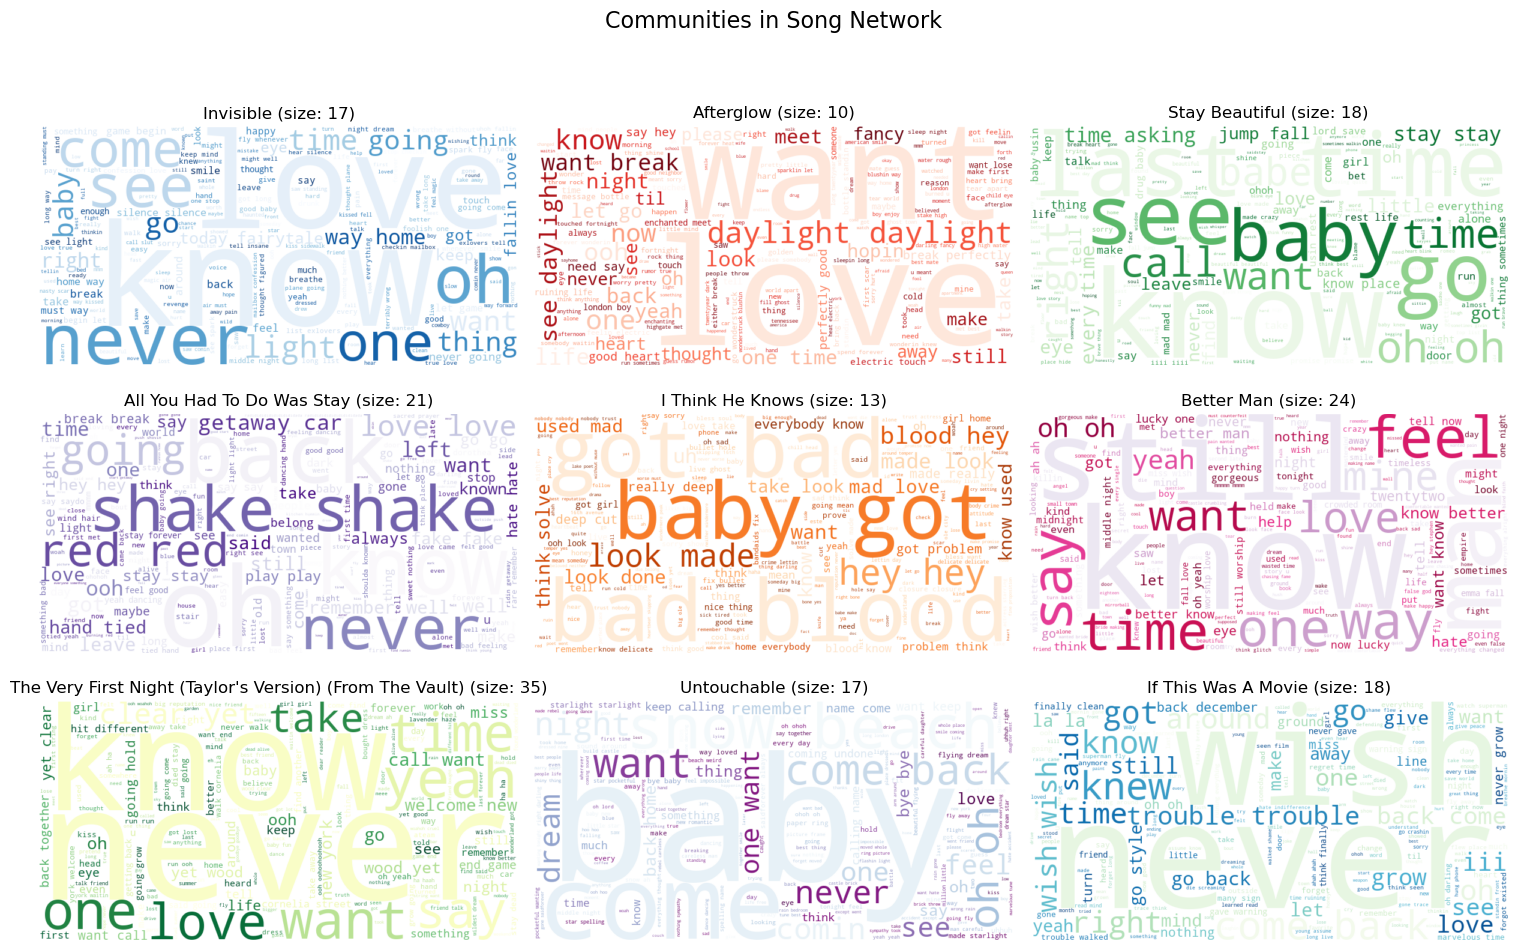

In [34]:
# Extract lyrics for each community
community_lyrics = {}
for comm_id, nodes in communities.items():
    community_lyrics[comm_id] = " ".join(
        updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
    )

# Define the number of rows and columns for the grid layout
num_communities = len(community_lyrics)
rows = (num_communities // 3) + (1 if num_communities % 3 else 0)
cols = min(3, num_communities)

# Create a colormap for different colors per community
# cmap = cm.get_cmap("tab10", num_communities)
colormap_names = ["Blues", "Reds", "Greens", "Purples", "Oranges", "PuRd",  "YlGn", "BuPu", "GnBu"]

# Generate the word clouds and organize them in a grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for i, (comm_id, lyrics) in enumerate(community_lyrics.items()):
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap=colormap_names[i] ,
        random_state=42 ,
    ).generate(lyrics)
    
    # Plot the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(
        f"{community_names[comm_id]} (size: {len(communities[comm_id])})",
        color='black'  # Set the title color to match the community color
    )

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a global title
plt.suptitle("Communities in Song Network", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust spacing to fit the title
plt.show()


In [35]:
# Function to compute word frequencies for each community
def compute_word_frequencies(community_lyrics, communities):
    community_word_data = []
    for comm_id, nodes in communities.items():
        # Tokenize lyrics for each song in the community
        community_songs = updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
        word_in_songs = Counter()
        total_word_counts = Counter()

        for song in community_songs:
            if isinstance(song, str):  # Ensure song is valid text
                words = set(song.split())  # Use set to avoid double-counting a word in the same song
                total_word_counts.update(song.split())
                word_in_songs.update(words)  # Count word appearances across songs

        # Most common words by total count
        most_common_total = total_word_counts.most_common(5)

        # Most common words by the number of songs they appear in
        most_common_unique = word_in_songs.most_common(5)

        # Append data for the community
        community_word_data.append({
            "Community": f"{comm_id}: {community_names[comm_id]}",
            "Most Common Words (Total Number)": most_common_total,
            "Top Words by Song Presence": most_common_unique,
            "Size": len(communities[comm_id])
        })

    return community_word_data

# Compute word frequencies for all communities
community_word_data = compute_word_frequencies(community_lyrics, communities)

# Convert to a DataFrame for visualization
df = pd.DataFrame(community_word_data)

# Extract the numeric prefix from the "Community" column and sort by it
df['Community Index'] = df['Community'].str.extract(r'^(\d+):', expand=False).astype(int)
df = df.sort_values(by='Community Index').drop(columns=['Community Index'])

# Reset the index after sorting
df = df.reset_index(drop=True)

pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', None)  


display(df)


Community  \
0                                                 0: Invisible   
1                                                 1: Afterglow   
2                                            2: Stay Beautiful   
3                                3: All You Had To Do Was Stay   
4                                          4: I Think He Knows   
5                                                5: Better Man   
6  6: The Very First Night (Taylor's Version) (From The Vault)   
7                                               7: Untouchable   
8                                       8: If This Was A Movie   

                                      Most Common Words (Total Number)  \
0         [(love, 82), (never, 62), (know, 57), (way, 53), (like, 47)]   
1     [(want, 64), (love, 56), (daylight, 40), (would, 28), (one, 27)]   
2          [(time, 106), (know, 80), (oh, 68), (baby, 51), (last, 44)]   
3            [(oh, 76), (love, 73), (shake, 70), (like, 66), (go, 51)]   
4          [(got, 142), (hey, 116), (know, 84), (look, 84), (bad, 74)]   
5         [(know, 124), (like, 101), (would, 96), (man, 57), (oh, 56)]   
6  [(want, 120), (never, 110), (would, 110), (like, 108), (know, 100)]   
7          [(like, 103), (oh, 84), (come, 80), (want, 62), (baby, 49)]   
8         [(would, 110), (wish, 88), (never, 86), (back, 72), (i, 72)]   

                                        Top Words by Song Presence  Size  
0      [(know, 14), (love, 13), (oh, 13), (like, 13), (never, 12)]    17  
1         [(love, 9), (want, 8), (like, 8), (back, 7), (would, 6)]    10  
2         [(know, 13), (oh, 13), (you, 13), (time, 12), (got, 11)]    18  
3        [(oh, 17), (like, 15), (could, 14), (go, 13), (ever, 13)]    21  
4         [(like, 12), (got, 10), (know, 10), (me, 9), (think, 9)]    13  
5       [(like, 21), (know, 20), (love, 16), (way, 14), (one, 14)]    24  
6    [(know, 26), (like, 25), (would, 23), (never, 22), (say, 21)]    35  
7       [(like, 16), (oh, 13), (would, 12), (back, 11), (you, 11)]    17  
8  [(would, 14), (know, 14), (never, 13), (could, 11), (like, 11)]    18

This table highlights key patterns in the communities formed within the song network. Communities with more songs, such as *"The Very First Night (Taylor’s Version) (From The Vault)"* (35 songs), demonstrate higher cohesion, as seen in their shared common words like *"know"* and *"like"* across numerous songs. This suggests strong thematic connections within larger communities.

Interestingly, communities with fewer songs, such as *"Afterglow"* (10 songs), still exhibit distinctive common words like *"want"* and *"love"*, but these words are less prevalent across the songs, reflecting a lower degree of thematic overlap. This implies smaller communities might explore more niche or varied topics.

The table also reveals a balance between shared themes and individuality. For example, while *"Invisible"* (17 songs) emphasizes universally relatable words like *"love"* and *"never"*, communities like *"Stay Beautiful"* focus on unique terms like *"time"* and *"baby"*, potentially indicating a more specific lyrical focus.

Overall, the size of a community correlates with its connectivity and thematic density. Larger communities tend to have higher internal cohesion through shared words, whereas smaller ones exhibit a mix of distinct and shared lyrical themes. This reflects the diversity in song topics and their grouping into interconnected communities.

The Top Words by Song Presence column shows how often a word appears across songs in a community. For example, in Community 0, words like never and love appear in most songs, indicating strong cohesion and a clear shared theme.

In [36]:
# Prepare the data for the table
community_metrics = []

for comm_id, nodes in communities.items():
    lyrics = updated_ts_data[updated_ts_data['track_name'].isin(nodes)]['cleaned_lyrics']
    
    # Calculate metrics
    num_songs = len(nodes)
    word_counts = [len(song.split()) for song in lyrics]
    num_words = sum(word_counts) / len(word_counts) if word_counts else 0
    unique_word_counts = [len(set(song.split())) for song in lyrics]
    num_unique = sum(unique_word_counts) / len(unique_word_counts) if unique_word_counts else 0
    percentage_unique = num_unique / num_words if num_words else 0
    average_length = sum(len(word) for song in lyrics for word in song.split()) / sum(word_counts) if word_counts else 0
    
    # Get the average degree in the community
    subgraph = gcc.subgraph(nodes)
    degrees = [degree for _, degree in subgraph.degree()]
    average_degree = sum(degrees) / len(degrees) if degrees else 0
    
    # Find the most common words
    all_words = Counter(word for song in lyrics for word in song.split())
    common_words = [f"{word} ({count})" for word, count in all_words.most_common(5)]
    
    # Append metrics for this community
    community_metrics.append({
        "Community": f"{comm_id}: {community_names[comm_id]}",
        "num_songs": num_songs,
        "num_words": round(num_words, 2),
        "num_unique": round(num_unique, 2),
        "percentage_unique": round(percentage_unique, 2),
        "average_length": round(average_length, 2),
        "average_degree": round(average_degree, 2),
        "common_words": ", ".join(common_words)
    })

# Create a DataFrame for the table
community_metrics_df = pd.DataFrame(community_metrics)

display(community_metrics_df)


Community  num_songs  \
0                                                 0: Invisible         17   
1                                                 1: Afterglow         10   
2                                            2: Stay Beautiful         18   
3                                3: All You Had To Do Was Stay         21   
4                                          4: I Think He Knows         13   
5                                                5: Better Man         24   
6  6: The Very First Night (Taylor's Version) (From The Vault)         35   
7                                               7: Untouchable         17   
8                                       8: If This Was A Movie         18   

   num_words  num_unique  percentage_unique  average_length  average_degree  \
0     171.29       81.12               0.47            4.80            3.65   
1     177.40       82.40               0.46            4.95            2.60   
2     160.72       75.33               0.47            4.55            2.89   
3     197.90       96.00               0.49            4.73            2.48   
4     231.54       84.08               0.36            4.43            3.69   
5     165.46       82.17               0.50            4.88            3.67   
6     186.91       88.77               0.47            4.76            3.43   
7     186.88       83.71               0.45            4.84            2.71   
8     188.28       87.22               0.46            4.77            3.00   

                                                   common_words  
0         love (82), never (62), know (57), way (53), like (47)  
1     want (64), love (56), daylight (40), would (28), one (27)  
2          time (106), know (80), oh (68), baby (51), last (44)  
3            oh (76), love (73), shake (70), like (66), go (51)  
4          got (142), hey (116), know (84), look (84), bad (74)  
5         know (124), like (101), would (96), man (57), oh (56)  
6  want (120), never (110), would (110), like (108), know (100)  
7          like (103), oh (84), come (80), want (62), baby (49)  
8         would (110), wish (88), never (86), back (72), i (72)

This table offers an insightful analysis of the song communities in terms of lexical variety, song length, and connectivity. A positive relationship is observed between the number of words and unique words, indicating that longer songs incorporate more diverse vocabulary rather than relying on repetition. Communities with higher numbers of songs also tend to have higher average degrees, reflecting denser connections due to more shared topics within the community.

Interestingly, there is a noticeable trend where communities with shorter songs tend to have higher average degrees, suggesting that shorter songs focus on more interconnected and common themes, whereas longer songs may delve into more unique or less connected topics. These patterns highlight both the cohesion within communities and the diversity in lyrical content across them.

# Compare album based communities with louvan communities.

For this comparison we will keep into account just the albumn of which we have critics reviews

Let's group the songs by album and compute their word cloud 

In [37]:
#extract the albums from the folder album_reviews
#the album names are the files names
album_metacritics = os.listdir("./data/album_reviews")
album_metacritics = [x.split(".")[0] for x in album_metacritics]

#remove _ coming from the file name
album_metacritics = [x.replace("_", " ") for x in album_metacritics]

#change the names of the albums in the metractics files so that they are the same as in the dataset
changed_albums = album_metacritics.copy()
for album in album_metacritics:
    if "THE TORTURED" in album:
        #change to lower case from the second letter for each word
        words = album.split(" ")
        new = ""
        for w in words:
            #keep the first letter and change the rest to lower case
            new += w[0] + w[1:].lower() + " "
        #remove the last space
        new = new[:-1]
        #replace the album name
        changed_albums[changed_albums.index(album)] = new

print(f'Number of album keeped: {len(changed_albums)}')

Number of album keeped: 16


In [38]:
changed_albums

['1989',
 "1989 (Taylor's Version)",
 'evermore',
 'Fearless',
 "Fearless (Taylor's Version)",
 'folklore',
 'Lover',
 'Midnights',
 'Red',
 "Red (Taylor's Version)",
 'reputation',
 'Speak Now',
 "Speak Now (Taylor's Version)",
 'Taylor Swift',
 'The Tortured Poets Department',
 'The Tortured Poets Department: The Anthology']

In [39]:
def belongs_to_changed_albums(albums):
    if isinstance(albums, list):  # Check if the album column is a list
        return any(album in changed_albums for album in albums)
    elif isinstance(albums, str):  # Check if it's a single string
        return albums in changed_albums
    return False  # Otherwise, return False

# Apply the filter to create a sub-dataframe
filtered_df = updated_ts_data[updated_ts_data['album'].apply(belongs_to_changed_albums)]

# Function to update the album list to only include names from changed_albums
def update_album_list(albums):
    if isinstance(albums, list):  # If it's a list, filter it
        return [album for album in albums if album in changed_albums]
    elif isinstance(albums, str):  # If it's a single string, check if it should be kept
        return [albums] if albums in changed_albums else []
    return []  # Return an empty list otherwise

# Update the album column
filtered_df['album'] = filtered_df['album'].apply(update_album_list)

# Reset index for the new dataframe
filtered_df = filtered_df.reset_index(drop=True)

print(filtered_df.shape)

(218, 28)


/tmp/ipykernel_12721/2903529644.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['album'] = filtered_df['album'].apply(update_album_list)


In [40]:
# Flatten the album column to handle lists
flattened_albums = filtered_df['album'].explode()

# Compute the number of unique albums
num_unique_albums = flattened_albums.nunique()

# Print the number of albums
print(f"Number of albums: {num_unique_albums}")

# Print the names of the albums
unique_albums = flattened_albums.unique()
print("Album names:")
for album in unique_albums:
    print(album)


Number of albums: 16
Album names:
1989 (Taylor's Version)
reputation
Taylor Swift
Lover
Red (Taylor's Version)
Midnights
1989
The Tortured Poets Department: The Anthology
The Tortured Poets Department
Fearless (Taylor's Version)
Speak Now (Taylor's Version)
evermore
folklore
Fearless
Speak Now
Red


In [41]:
# Assign each song to its communities

In [42]:
album_communities = defaultdict(list)

# Iterate through the dataframe
for _, row in filtered_df.iterrows():
    track_name = row['track_name']
    albums = row['album']  # Can be a list or a single string
    
    # If `albums` is a list, iterate through it; otherwise, treat it as a single album
    if isinstance(albums, list):
        for album in albums:
            album_communities[album].append(track_name)
    else:
        album_communities[albums].append(track_name)

# Convert defaultdict to a regular dictionary
album_communities = dict(album_communities)


In [43]:
sorted_album_communities = dict(sorted(album_communities.items(), key=lambda x: x[0]))
sorted_album_communities

{'1989': ['Bad Blood',
  'How You Get The Girl',
  'Out Of The Woods',
  'Style',
  'This Love',
  'I Know Places',
  'All You Had To Do Was Stay',
  'Clean',
  'I Wish You Would',
  'Welcome To New York',
  'Wildest Dreams',
  'Blank Space',
  'Shake It Off'],
 "1989 (Taylor's Version)": ['"Slut!" (Taylor\'s Version) (From The Vault)',
  "Bad Blood (Taylor's Version)",
  "Is It Over Now? (Taylor's Version) (From The Vault)",
  "Now That We Don't Talk (Taylor's Version) (From The Vault)",
  "Say Don't Go (Taylor's Version) (From The Vault)",
  "Suburban Legends (Taylor's Version) (From The Vault)",
  'How You Get The Girl',
  'Out Of The Woods',
  'Style',
  'Wonderland',
  'This Love',
  'I Know Places',
  'All You Had To Do Was Stay',
  'Clean',
  'I Wish You Would',
  'Welcome To New York',
  'You Are In Love',
  'New Romantics',
  'Wildest Dreams',
  'Blank Space',
  'Shake It Off'],
 'Fearless': ['Tell Me Why',
  'You Belong With Me',
  'White Horse',
  'The Way I Loved You',
  'T

In [44]:
# For each community (album) extract the lyrics 
album_communities_lyrics = {}
for album_name, songs in album_communities.items():
    album_communities_lyrics[album_name] = " ".join(
        filtered_df[filtered_df['track_name'].isin(songs)]['cleaned_lyrics']
    )
album_communities_lyrics

{"1989 (Taylor's Version)": 'flamingo pink sunrise boulevard clink clink young art aquamarine moonlit swimmin pool need you got lovestruck went straight head got lovesick bed love think never forget handprints wet cement adorned smoke clothes lovelorn nobody know love thorn rose pay price dressed might well lookin u call slut know might worth going drunk might well drunk love send code waitin stick stone throw froze midair everyone want him crime wrong place right time break down pullin world boy gentleman got lovestruck went straight head straight head got lovesick bed over bed love think never forget pay price guess dressed if dressed up might well lookin u lookin u call slut if call slut know might worth worth once going drunk might well drunk love half asleep takin time tangerine neon light luxury sayin love going half awake takin chance big mistake saidit might blow pretty face sayindo anyway do anyway going up call slut know might worth going drunk might well drunk love because b

In [45]:
# Sort the keys alphabetically and create a new dictionary
album_communities_lyrics_sorted = {
    key: album_communities_lyrics[key]
    for key in sorted(album_communities_lyrics.keys())
}

# Display the sorted dictionary
album_communities_lyrics_sorted


{'1989': 'because baby got bad blood know used mad love uh take look done uh because baby got bad blood uh hey hey cannot take back look uh og like doc remember that remember that tlc quite od id fact id my pov me similar iraq hate you hate critique overrate beat dark heart use basslines replace take time erase you love hear more no fear better yet respect quite sincere oh sad think good time because baby got bad blood know used mad love take look done because baby got bad blood hey got problem think solve uh made really deep cut uh and baby got bad blood hey hey remember tried write off haha remember thought would take loss remember thought would need ya follow procedure remember oh wait got amnesia season battle wound battle scar body bumped bruised stabbed back brimstone fire jumpin still life got money power got live bad blood haha oh sad think good time because baby got bad blood hey hey hey hey know used mad love hey hey hey hey take look done hey hey hey hey because baby got bad

IndexError: list index out of range

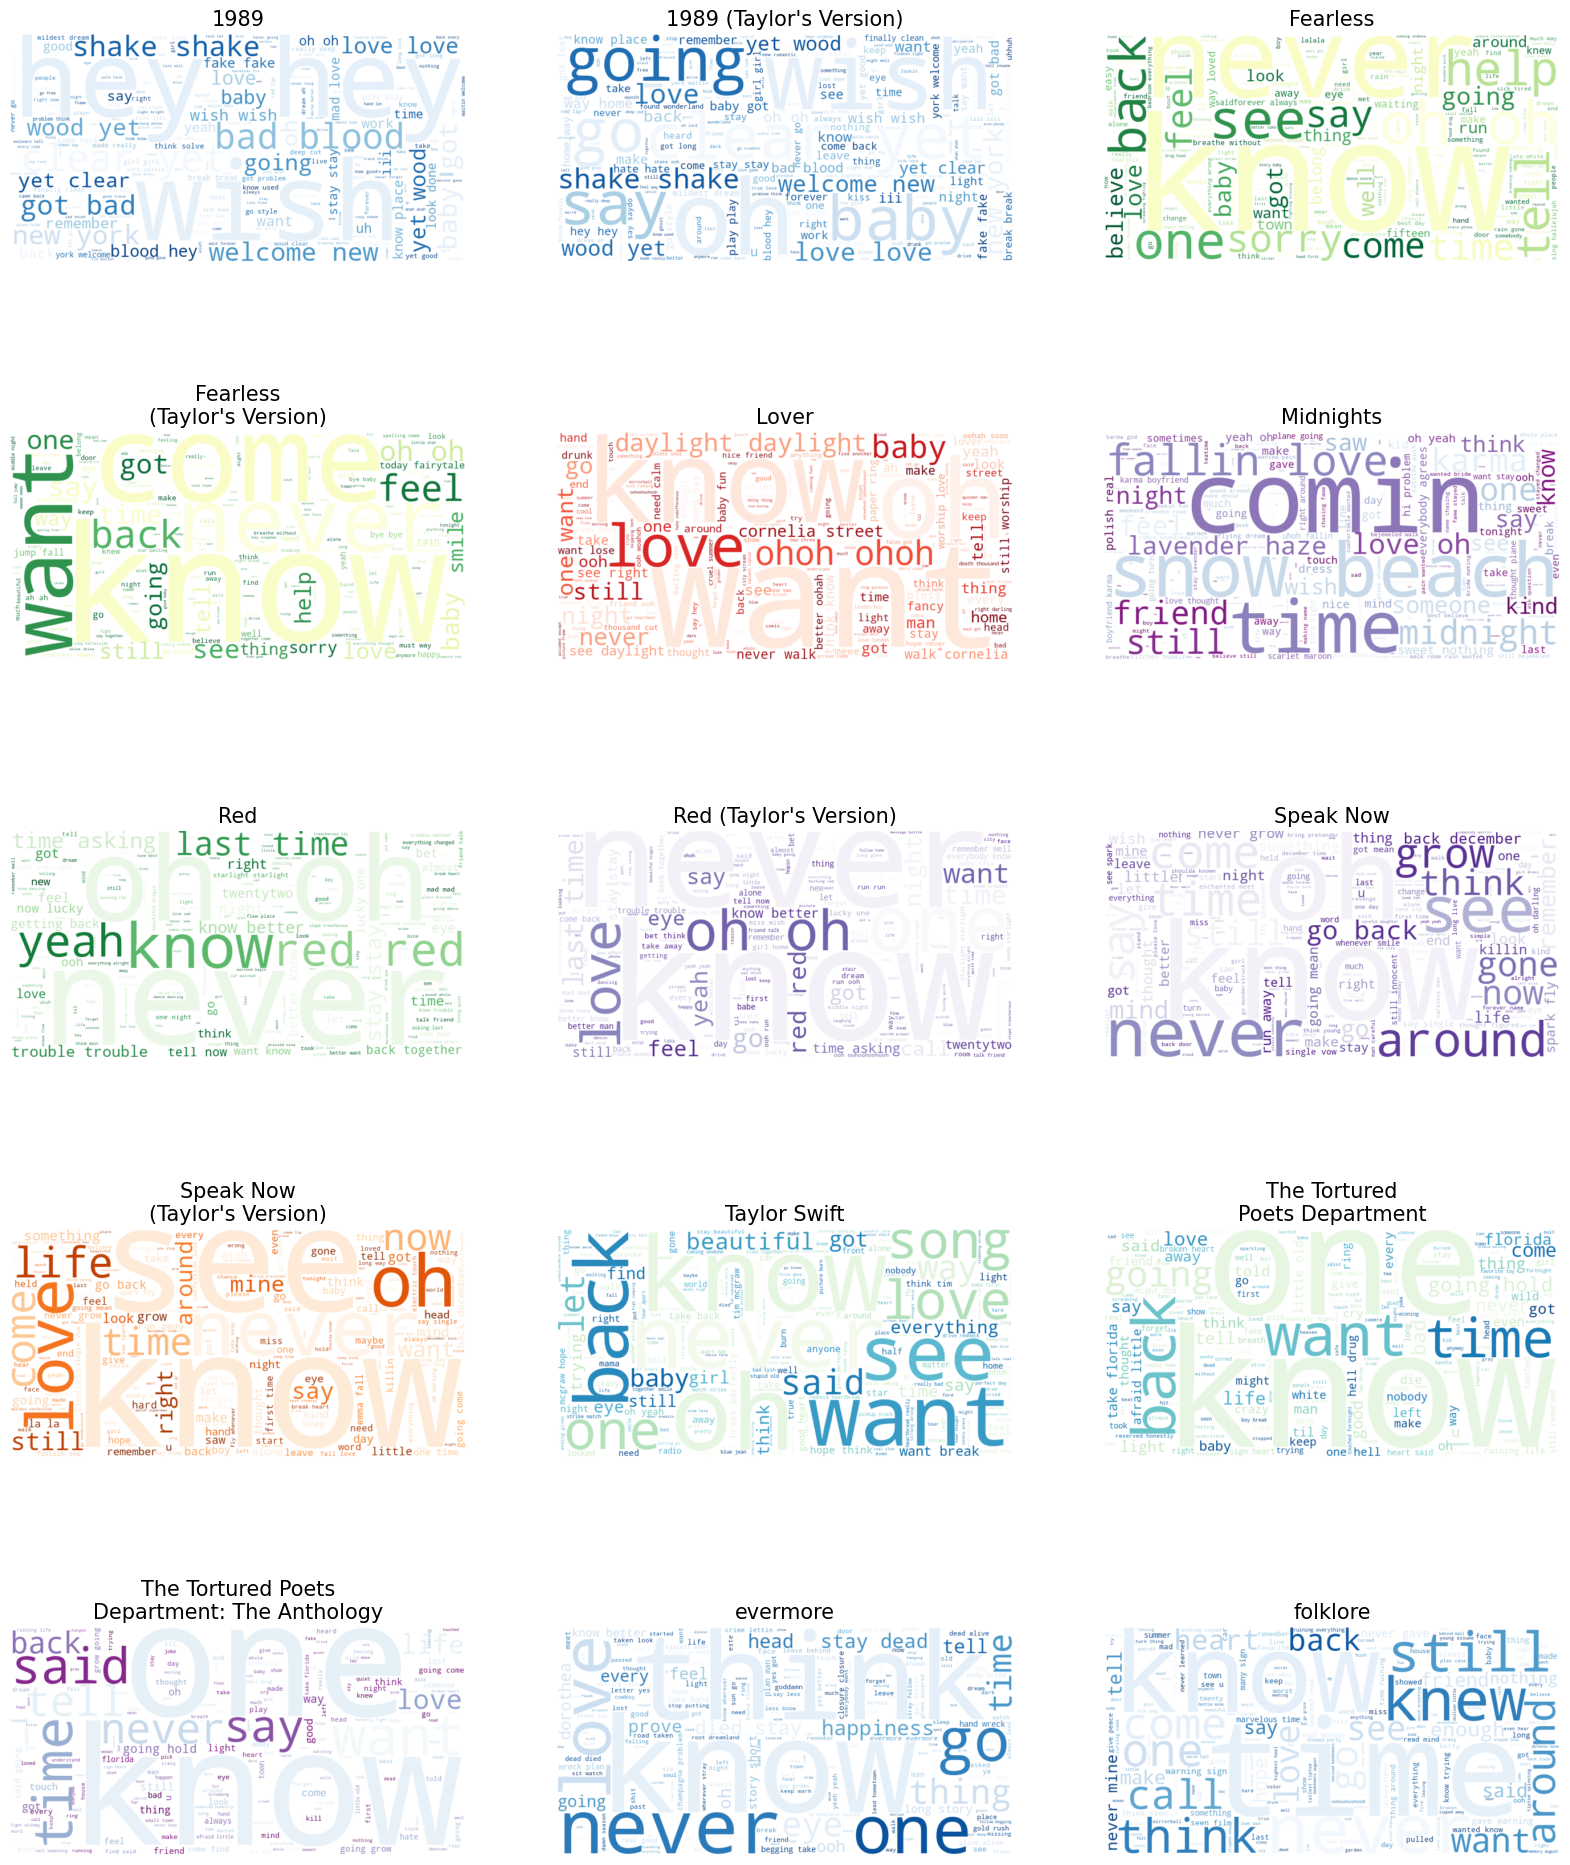

In [46]:
# Define a list of colormaps
colormap_names = ["Blues", "Blues", 
                  "YlGn", "YlGn",
                  "Reds", 
                  "BuPu",
                  "Greens", 
                  "Purples", "Purples", 
                  "Oranges", 
                  "GnBu", "GnBu",
                  "BuPu", 
                  "Blues", "Blues", 
                ]

# Define rows and columns for the grid
rows = 5
cols = 3

# Create the grid plot
fig, axes = plt.subplots(rows, cols, figsize=(20, 25))
axes = axes.flatten()

# Function to wrap album titles more elegantly
def wrap_title(title, max_length=25):
    if len(title) <= max_length:
        return title
    words = title.split()
    mid_point = len(words) // 2
    line_1 = " ".join(words[:mid_point])
    line_2 = " ".join(words[mid_point:])
    return f"{line_1}\n{line_2}"

# Plot each word cloud
for i, (album, lyrics) in enumerate(album_communities_lyrics_sorted.items()):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap_names[i],
        random_state=42
    ).generate(lyrics)
    
    # Plot the word cloud
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis("off")
    # Put in two lines if the title if it is too long
    max_length = 25
    formatted_title = wrap_title(album)
    axes[i].set_title(formatted_title, fontsize=15)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a global title
plt.suptitle("Word Clouds for Albums", fontsize=29)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust spacing to fit the title
plt.show()



In [ ]:
# Calculate the number of songs in each album community
album_song_counts = {album: len(set(songs)) for album, songs in album_communities.items()}

# Convert to a DataFrame for better visualization
album_song_counts_df = pd.DataFrame(list(album_song_counts.items()), columns=["Album", "Number of Songs"])

# Sort the DataFrame by the number of songs in descending order
album_song_counts_df = album_song_counts_df.sort_values(by="Number of Songs", ascending=False).reset_index(drop=True)

# Display the DataFrame
display(album_song_counts_df)


Album  Number of Songs
0   The Tortured Poets Department: The Anthology               31
1                    Fearless (Taylor's Version)               25
2                   Speak Now (Taylor's Version)               22
3                        1989 (Taylor's Version)               21
4                                          Lover               18
5                                       folklore               16
6                  The Tortured Poets Department               16
7                                            Red               16
8                                       evermore               15
9                                     reputation               15
10                                  Taylor Swift               14
11                                     Speak Now               14
12                                     Midnights               13
13                                          1989               13
14                                      Fearless               13

In [ ]:
# Function to compute word frequencies for album-based communities
def compute_word_frequencies_albums(album_lyrics, album_communities):
    album_word_data = []
    for album_name, songs in album_communities.items():
        # Ensure `songs` is always treated as a list
        if isinstance(songs, str):
            flat_song_list = [songs]  # If it's a single string, wrap it in a list
        else:
            flat_song_list = list(songs)  # Otherwise, convert it to a list (if it's not already)

        # Tokenize lyrics for each song in the album
        album_songs = filtered_df[filtered_df['track_name'].isin(flat_song_list)]['cleaned_lyrics']
        word_in_songs = Counter()
        total_word_counts = Counter()

        for song in album_songs:
            if isinstance(song, str):  # Ensure song is valid text
                words = set(song.split())  # Use set to avoid double-counting a word in the same song
                total_word_counts.update(song.split())
                word_in_songs.update(words)  # Count word appearances across songs

        # Most common words by total count
        most_common_total = total_word_counts.most_common(5)

        # Most common words by the number of songs they appear in
        most_common_unique = word_in_songs.most_common(5)

        # Append data for the album
        album_word_data.append({
            "Album": album_name,
            "Most Common Words (Total Number)": most_common_total,
            "Top Words by Song Presence": most_common_unique,
            "Size": len(flat_song_list)
        })

    return album_word_data

# Compute word frequencies for all album-based communities
album_word_data = compute_word_frequencies_albums(album_communities_lyrics_sorted, sorted_album_communities)

# Convert to a DataFrame for visualization
df_album = pd.DataFrame(album_word_data)

# Sort by Album names alphabetically
df_album = df_album.sort_values(by='Album').reset_index(drop=True)

# Set pandas options for better display
pd.set_option('max_colwidth', 200)
pd.set_option('display.max_columns', None)

# Display the DataFrame
display(df_album)



Album  \
0                                           1989   
1                        1989 (Taylor's Version)   
2                                       Fearless   
3                    Fearless (Taylor's Version)   
4                                          Lover   
5                                      Midnights   
6                                            Red   
7                                      Speak Now   
8                   Speak Now (Taylor's Version)   
9                                   Taylor Swift   
10                 The Tortured Poets Department   
11  The Tortured Poets Department: The Anthology   
12                                      evermore   
13                                      folklore   
14                                    reputation   

                                   Most Common Words (Total Number)  \
0          [(i, 100), (love, 88), (hey, 83), (wish, 81), (got, 70)]   
1        [(love, 108), (i, 101), (oh, 90), (wish, 81), (shake, 70)]   
2       [(know, 61), (oh, 50), (cannot, 29), (never, 26), (no, 26)]   
3         [(know, 89), (oh, 71), (come, 57), (like, 51), (you, 45)]   
4     [(want, 88), (would, 71), (like, 67), (love, 48), (know, 48)]   
5      [(like, 52), (karma, 28), (love, 25), (comin, 25), (oh, 23)]   
6       [(like, 80), (know, 77), (time, 69), (oh, 64), (never, 57)]   
7    [(like, 47), (know, 37), (would, 36), (never, 35), (back, 32)]   
8     [(would, 76), (like, 65), (know, 62), (see, 57), (never, 53)]   
9      [(oh, 45), (know, 37), (want, 33), (would, 28), (think, 26)]   
10      [(going, 40), (you, 38), (one, 37), (like, 36), (know, 35)]   
11     [(like, 79), (going, 77), (one, 63), (know, 59), (said, 54)]   
12  [(know, 49), (like, 48), (could, 31), (would, 30), (think, 27)]   
13   [(would, 50), (never, 46), (time, 45), (know, 45), (like, 41)]   
14     [(want, 88), (made, 53), (like, 52), (look, 48), (call, 47)]   

                                       Top Words by Song Presence  Size  
0       [(could, 11), (know, 10), (like, 10), (back, 9), (go, 8)]    13  
1   [(back, 15), (know, 14), (like, 14), (could, 13), (love, 12)]    21  
2        [(know, 11), (say, 11), (oh, 10), (never, 9), (like, 9)]    13  
3        [(know, 19), (say, 18), (oh, 17), (like, 17), (you, 16)]    25  
4       [(like, 15), (want, 12), (you, 12), (know, 11), (go, 10)]    18  
5        [(like, 9), (time, 9), (love, 7), (going, 7), (feel, 6)]    13  
6      [(like, 14), (time, 14), (know, 12), (oh, 10), (would, 9)]    16  
7   [(like, 13), (would, 11), (know, 11), (you, 11), (never, 10)]    14  
8   [(like, 21), (know, 19), (never, 16), (would, 16), (you, 14)]    22  
9            [(oh, 11), (know, 10), (one, 8), (way, 8), (see, 8)]    14  
10    [(like, 13), (one, 13), (say, 11), (know, 10), (would, 10)]    16  
11   [(like, 26), (one, 23), (know, 21), (would, 19), (time, 16)]    31  
12     [(know, 12), (would, 12), (like, 11), (go, 9), (could, 8)]    15  
13   [(would, 12), (know, 11), (like, 11), (time, 11), (one, 10)]    16  
14          [(oh, 13), (like, 12), (me, 10), (you, 9), (time, 9)]    15

# Recompute the louvain communities but just for the subset of the dataset belonging to the albumns for which we have critics


In [ ]:
# Convert the network to an undirected graph
undirected_graph = net.to_undirected()

# Get the nodes that belong to the filtered_df dataframe
nodes_to_keep = filtered_df['track_name'].unique()

# Create a subgraph of the network with the nodes to keep
net_album = undirected_graph.subgraph(nodes_to_keep)

largest_cc = max(nx.connected_components(net_album), key=len)
gcc = undirected_net.subgraph(largest_cc).copy()
print(f"GCC has {gcc.number_of_nodes()} nodes and {gcc.number_of_edges()} edges")


GCC has 156 nodes and 397 edges


In [ ]:
# # Detect communities in the GCC
# partition_album_net = community_louvain.best_partition(gcc, random_state=42)

# # Save the partition to ensure consistency
# with open("partition_album_net.pkl", "wb") as f:
#     pickle.dump(partition_album_net, f)

In [ ]:
with open("partition_album_net.pkl", "rb") as f:
    partition_album_net = pickle.load(f)

# Compute modularity for the GCC
modularity_album_net = community_louvain.modularity(partition_album_net, gcc)
print(f"Number of communities in GCC: {len(set(partition_album_net.values()))}")
print(f"Modularity value for GCC: {modularity_album_net}")

Number of communities in GCC: 10
Modularity value for GCC: 0.47077536144609855


In [ ]:
communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

community_names = {}
for comm_id, nodes in communities.items():
    # Compute degree for each node in the community
    degrees = {node: undirected_net.degree(node) for node in nodes}
    # Find the node with the highest degree
    highest_degree_node = max(degrees, key=degrees.get)
    community_names[comm_id] = highest_degree_node

print("Communities named by highest-degree song:")
print(community_names)

Communities named by highest-degree song:
{0: 'Invisible', 1: 'Afterglow', 2: 'Stay Beautiful', 3: 'All You Had To Do Was Stay', 4: 'I Think He Knows', 5: 'Better Man', 6: "The Very First Night (Taylor's Version) (From The Vault)", 7: 'Untouchable', 8: 'If This Was A Movie'}


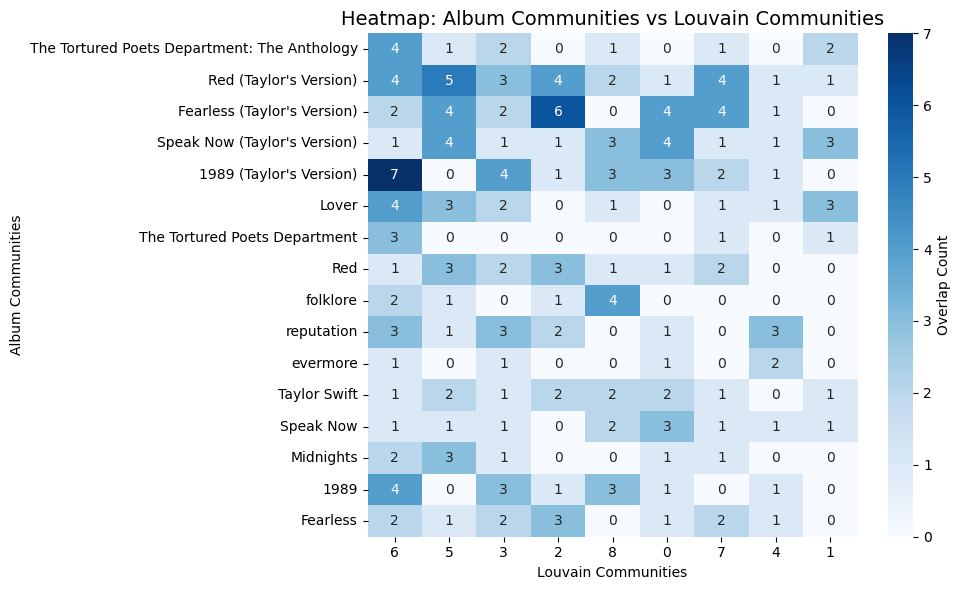

In [ ]:
# Example: Compute sizes of album communities
album_sizes = {album: len(songs) for album, songs in album_communities.items()}
top_albums = sorted(album_sizes, key=album_sizes.get, reverse=True)# [:5]  # Top 5 albums

# Example: Compute sizes of Louvain communities
louvain_sizes = {community: len(nodes) for community, nodes in communities.items()}
top_louvain = sorted(louvain_sizes, key=louvain_sizes.get, reverse=True) # [:5]  # Top 5 Louvain communities

# Initialize confusion matrix
confusion_matrix = pd.DataFrame(0, index=top_albums, columns=top_louvain)

# Populate the confusion matrix
for album in top_albums:
    for louvain_comm in top_louvain:
        # Count overlap between album and Louvain communities
        album_songs = set(album_communities[album])
        louvain_songs = set(communities[louvain_comm])
        overlap = len(album_songs.intersection(louvain_songs))
        confusion_matrix.at[album, louvain_comm] = overlap

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar_kws={'label': 'Overlap Count'}
)
plt.title("Heatmap: Album Communities vs Louvain Communities", fontsize=14)
plt.xlabel("Louvain Communities")
plt.ylabel("Album Communities")
plt.tight_layout()
plt.show()


!!! IMPORTANT TO DISCUSS

LOUVAIN COMMUNITIES COMES FROM BIGGEST CONNECT COMPONENT GRAPH WHILE ALBUM BASED COMMUNITIES COMES FROM THE DATAFRAME SO THEY HAVE DIFFERENT SHAPE SO THE HEAT MAP IN THE ROWS DOESN'T SHOW THE SUM OF THE ELEMENTS OF THE COMMUNITY